# ECE549: Image Processing and Sampling

This notebook covers fundamental image processing operations from Weeks 1 and 2 using Python and its scientific computing libraries. The goal is to provide a hands-on implementation of the following concepts:

- **Image Loading and Channel Separation:** Loading an image and splitting it into its individual color channels.
- **Translation:** Shifting an image's position.
- **Rotation:** Applying rotation with both nearest-neighbor and bilinear interpolation.
- **Scaling:** Resizing an image using nearest-neighbor and bilinear interpolation.
- **Affine Warp:** Combining translation, rotation, and scaling into a single transformation.
- **Projective Warp:** Applying a perspective transformation to an image.
- **Channel Registration:** Aligning color channels to correct for displacement.

Each section below contains Python code and a brief explanation of the process.

### Image Loading and Channel Separation:
Loading an image and splitting it into its individual color channels

In [1]:
# Import modules
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Load the chicken image
image_path = "/home/rashiqul/workspace/ece549/picture/Chicken.jpg"


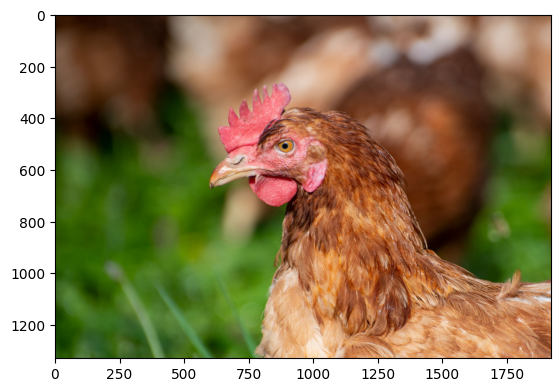

Image size: (1920, 1329)


In [3]:
# Load the image as it is and display it
image = Image.open(image_path)
plt.imshow(image)
plt.show()

# Print image dimensions
print(f"Image size: {image.size}")

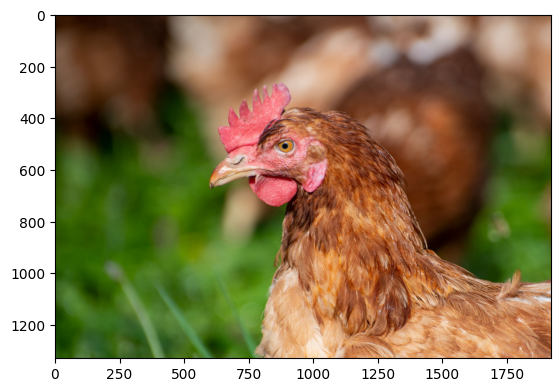

Image size: (1920, 1329)


In [4]:
# Load the image, convert to RGB and display it
image_rgb = Image.open(image_path).convert("RGB")
plt.imshow(image_rgb)
plt.show()

# Print image dimensions
print(f"Image size: {image_rgb.size}")

Numpy array dimensions: (1329, 1920, 3)
Image size: 7655040


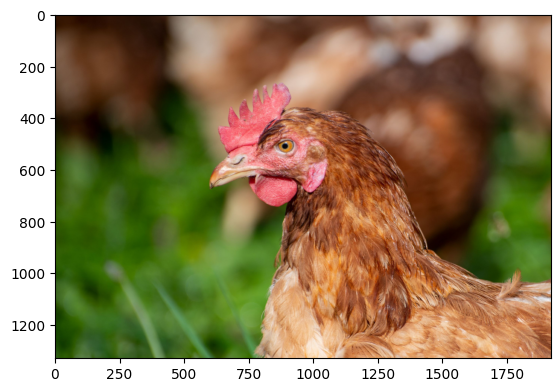

In [5]:
# Normalize the image to [0, 1] range and display it
image_np = np.array(image_rgb) / 255.0
# Display the normalized image
plt.imshow(image_np)

# Print image dimensions
print(f"Numpy array dimensions: {image_np.shape}")
print(f"Image size: {image_np.size}")

In [6]:
# Print the image dimension and data type
print("Image shape:", image_np.shape)
print("Data type:", image_np.dtype)

print("\n")

# Print the array content (first 5 rows and columns for brevity)
print("Image array content (first 5 rows and columns):")
print(image_np[:5, :5, :])  # Print a small portion of the

Image shape: (1329, 1920, 3)
Data type: float64


Image array content (first 5 rows and columns):
[[[0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]]

 [[0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]]

 [[0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]]

 [[0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]]

 [[0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.20392157 0.09019608 0.01960784]
  [0.2

In [7]:
# Split chicken into R, G, B channels
r_channel = image_np[:, :, 0]
g_channel = image_np[:, :, 1]
b_channel = image_np[:, :, 2]


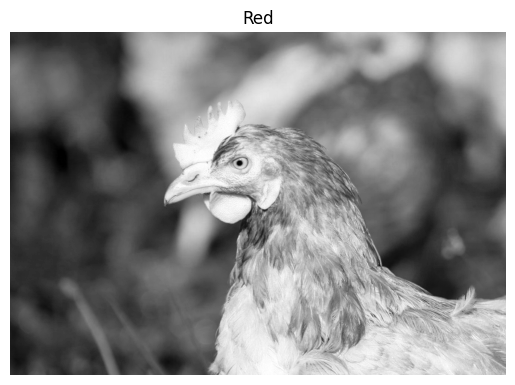

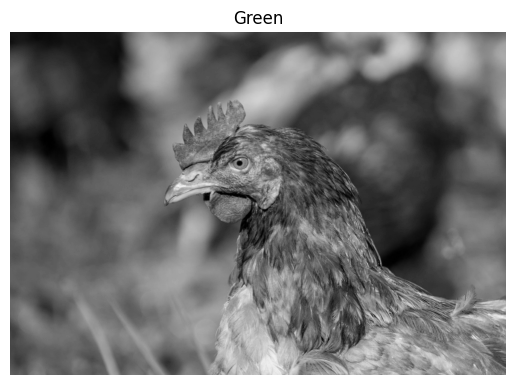

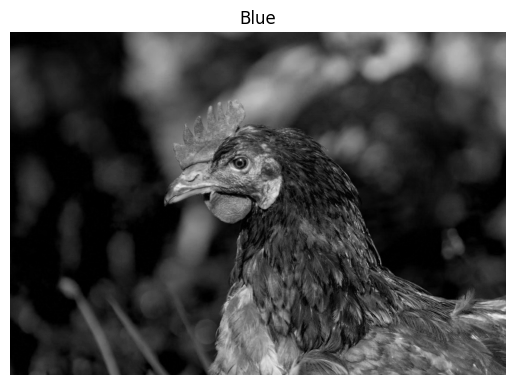

In [8]:
# Display the R, G, B channels in gray scale
for channel, name in zip([r_channel, g_channel, b_channel], ['Red', 'Green', 'Blue']):
    plt.imshow(channel, cmap='gray')
    plt.title(name)
    plt.axis('off')
    plt.show()


### Translation
Translation is the simplest geometric transform, shifting every pixel by an offset `(tx, ty)` according to the formula:
* `(u, v) = (x + tx, y + ty)`
* As a rigid motion, it preserves all lengths, angles, and orientation.
* It is a fundamental step in image registration (e.g., aligning color channels).

In [9]:
def translate_image(image, tx, ty):
    """
    Translates image by (tx, ty).
    - postive  tx equals shift by right
    - positive ty equals shift down
    Out-of-bound pixels are filled with black (0).
    """
    # Get image dimensions
    height, width = image.shape[:2]
    # Create an output image filled with zeros (black)
    output = np.zeros_like(image)

    # Compute valid ranges (overlapping region between source and target)
    # Destination (output) region
    x0  = max(0, tx)
    x1  = min(width, width + tx)
    y0  = max(0, ty)
    y1  = min(height, height + ty)

    # Source (input) region
    sx0 = max(0, -tx)
    sx1 = sx0 + (x1 - x0)
    sy0 = max(0, -ty)
    sy1 = sy0 + (y1 - y0)

    # Copy the valid region
    output[y0:y1, x0:x1, :] = image[sy0:sy1, sx0:sx1, :]
    return output


Original image dimensions: (1329, 1920, 3)
Original image size: 7655040
Numpy array dimensions: (1329, 1920, 3)
Image size: 7655040


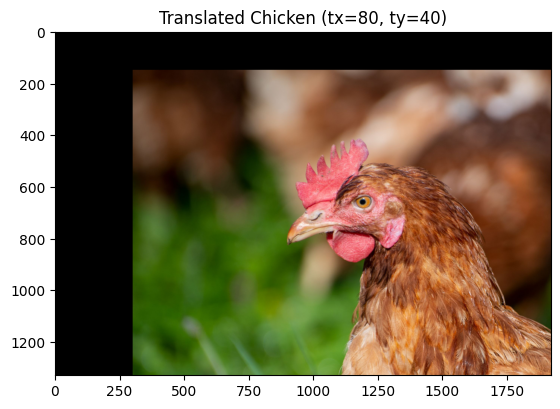

In [10]:
# Orignal image dimensions
print(f"Original image dimensions: {image_np.shape}")
print(f"Original image size: {image_np.size}")

# Try shifting the chicken image by (300, 150)
image_shifted = translate_image(image_np, 300, 150)
# Display the shifted image
plt.imshow(image_shifted)
plt.title("Translated Chicken (tx=80, ty=40)")

# Print image dimensions
print(f"Numpy array dimensions: {image_shifted.shape}")
print(f"Image size: {image_shifted.size}")

### Rotation
Rotation is a rigid motion (preserves length/angles in continuous space) according to the formula:
* `(u, v) = R_theta * (x, y)`
* In practice we scan target pixels and sample from source using a re-sampler
* Here we will use PIL's rotate, which handles center rotation + inverse mapping for us. 

In [11]:
# Convert numpy array back to PIL Image for rotation
image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

# Display original PIL image size
print(f"PIL image size: {image_pil.size}")
# Show first 5 rows and columns of the original image array
print("Original image array content (first 5 rows and columns):")
print(np.array(image_pil)[:5, :5, :])

PIL image size: (1920, 1329)
Original image array content (first 5 rows and columns):
[[[52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]]

 [[52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]]

 [[52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]]

 [[52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]]

 [[52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]
  [52 23  5]]]


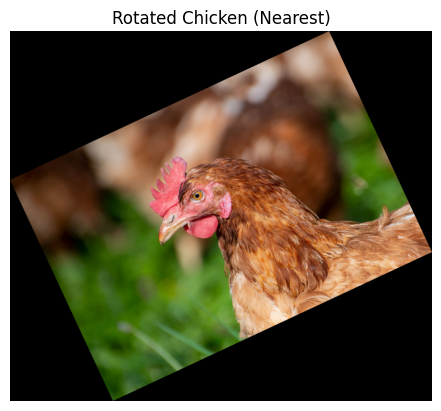

Nearest rotated image size: (2302, 2017)
Nearest rotated image array content (first 5 rows and columns):
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


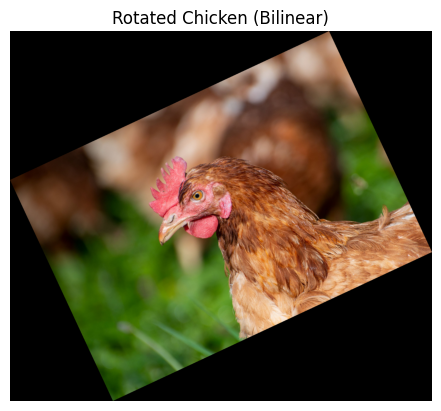

Bilinear rotated image size: (2302, 2017)
Bilinear rotated image array content (first 5 rows and columns):
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [12]:
# Rotate around center, expand=True so the canvas grows to fit
image_rot_nearest  = image_pil.rotate(25, resample=Image.NEAREST, expand=True)
image_rot_bilinear = image_pil.rotate(25, resample=Image.BILINEAR, expand=True)

# Display the rotated images
for img, method in zip([image_rot_nearest, image_rot_bilinear], ['Nearest', 'Bilinear']):
    plt.imshow(img)
    plt.title(f"Rotated Chicken ({method})")
    plt.axis('off')
    plt.show()

    # Print rotated image dimensions
    print(f"{method} rotated image size: {img.size}")
    print(f"{method} rotated image array content (first 5 rows and columns):")
    print(np.array(img)[:5, :5, :])  # Print a small portion of the array